In [1]:
#!pip install pyomo

import numpy as np
import pyomo.environ as pyo
from pathlib import *
from pyomo.opt import SolverFactory
from gurobipy import *

import os
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import time
import math

from datetime import datetime

# Main Algorithm

In [2]:
def compute_switch_over(tilde_m, tilde_m_squared):
    m = 1
    
    coordinates_queue_centers = []
    for j in range(tilde_m)[::-1]:
        for i in range(tilde_m):
            coordinates_queue_centers.append([round((1/(tilde_m+tilde_m)) + (i/tilde_m),14), round((1/(tilde_m+tilde_m)) + (j/tilde_m),14)])
                
    theta = np.zeros((tilde_m_squared+1, tilde_m_squared+1), dtype=float)
    for i in range(tilde_m_squared+1):
        for j in range(tilde_m_squared+1):
            if (i == 0 and j > 0):
                distance = np.sqrt((((m/2) - coordinates_queue_centers[j-1][0])**2) + (((m/2) - coordinates_queue_centers[j-1][1])**2))
                theta[i][j] = round(distance, 14)
                theta[j][i] = round(distance, 14)
            elif (i < j):
                distance = np.sqrt(((coordinates_queue_centers[i-1][0] - coordinates_queue_centers[j-1][0])**2) + ((coordinates_queue_centers[i-1][1] - coordinates_queue_centers[j-1][1])**2))
                theta[i][j] = round(distance, 14)
                theta[j][i] = round(distance, 14)
    return theta, coordinates_queue_centers

tilde_m = 50
tilde_m_squared = tilde_m**2; # Number of subregion in A

theta_incl, coordinates_queue_centers = compute_switch_over(tilde_m, tilde_m_squared)



In [3]:
class reward_object:
    def __init__(self, index, value):
        self.index = index
        self.value = value
        
def check_nonempty_queues_path(next_queue_index, I_min, tilde_n_min, cur_queue_index, theta, status_traveler, all_reward_values, coordinates_queue_centers, mu, arrival_rate_Q):
    # ADD Check if there is a nonempty queue on the path to next_queue_index
    global tilde_m
    reward_queue_index = next_queue_index

    distance_current_reward = theta[cur_queue_index][next_queue_index]
    
    num_nonempty_queues_path = len(I_min)-1
    rho_Q = arrival_rate_Q*mu
    
    changed_bool = 0
    
    direct_indirect_local_rewards = [0.0]*len(I_min)
    indices_queues_on_path = []
    
    for index in range(1,num_nonempty_queues_path+1):
        considered_queue_index = I_min[index]
        if (considered_queue_index == reward_queue_index):
            indices_queues_on_path.append(index)
        else:
            distance_current_considered = theta[cur_queue_index][considered_queue_index]
            distance_considered_reward = theta[considered_queue_index][reward_queue_index]
                        
            if (distance_current_considered + distance_considered_reward < 2*distance_current_reward):
                indices_queues_on_path.append(index)
    
    gamma = len(indices_queues_on_path)-1
    for direct_index_I_min in indices_queues_on_path:
        direct_queue_index = I_min[direct_index_I_min]
        direct_reward_on_path = np.longdouble(tilde_n_min[direct_index_I_min]/theta[cur_queue_index][direct_queue_index])
        appeared_during_BP_and_travel = ((((tilde_n_min[direct_index_I_min]+(theta[cur_queue_index][direct_queue_index]*arrival_rate_Q))*mu)/(1-rho_Q))+ theta[cur_queue_index][direct_queue_index])*arrival_rate_Q

        reward_sum_next_next = 0.0
        for indirect_index_I_min in indices_queues_on_path:
            if (indirect_index_I_min != direct_index_I_min):
                indirect_queue_index = I_min[indirect_index_I_min]
                distance_direct_to_indirect = theta[direct_queue_index][indirect_queue_index]
                reward_sum_next_next += np.longdouble((tilde_n_min[indirect_index_I_min]+appeared_during_BP_and_travel+(distance_direct_to_indirect*arrival_rate_Q))/distance_direct_to_indirect)

        if (reward_sum_next_next > 0):
            next_reward_value = direct_reward_on_path + np.longdouble(reward_sum_next_next/gamma)
        else: 
            next_reward_value = direct_reward_on_path
        direct_indirect_local_rewards[direct_index_I_min] = next_reward_value   
        
    min_distance_queue_on_route = distance_current_reward
    max_direct_indirect_reward = 0.0
    for k in indices_queues_on_path:
        considered_queue_index = I_min[k]
        if (considered_queue_index != reward_queue_index):
            distance_current_considered = theta[cur_queue_index][considered_queue_index]
            distance_considered_reward = theta[considered_queue_index][reward_queue_index]
            
            considered_direct_indirect_reward = direct_indirect_local_rewards[k]

            if (distance_current_considered < min_distance_queue_on_route):
                next_queue_index = considered_queue_index
                min_distance_queue_on_route = distance_current_considered
                max_direct_indirect_reward = considered_direct_indirect_reward
                changed_bool = 1
                
            elif (distance_current_considered == min_distance_queue_on_route):
                if (considered_direct_indirect_reward > max_direct_indirect_reward):
                    next_queue_index = considered_queue_index
                    min_distance_queue_on_route = distance_current_considered
                    max_direct_indirect_reward = considered_direct_indirect_reward
                    changed_bool = 1
    
    return next_queue_index, changed_bool

        
def compute_rewards(I_min, tilde_n_min, theta_min, theta, status_traveler, arrival_rate_Q, coordinates_queue_centers, mu):
    global m
    
    num_nonempty_queues = len(I_min)-1
    cur_queue_index = I_min[0]
            
    max_reward_value = 0.0
    max_reward_queue_index = 0
    gamma = num_nonempty_queues - 1 
    rho_Q = arrival_rate_Q*mu
    
    all_reward_values = [0.0]*(num_nonempty_queues+1)
    
    # Direct rewards 
    for i in range(1,num_nonempty_queues+1):
        next_queue_reward = I_min[i]
        distance_current_to_next = theta[cur_queue_index][next_queue_reward]

        appeared_during_BP_and_travel = ((((tilde_n_min[i]+(distance_current_to_next*arrival_rate_Q))*mu)/(1-rho_Q))+ distance_current_to_next)*arrival_rate_Q
        
        reward_sum_next_next = 0.0
        for j in range(1,num_nonempty_queues+1):
            next_next_queue = I_min[j]
            distance_next_to_nextnext = theta[next_queue_reward][next_next_queue]
            if (next_next_queue != next_queue_reward):                
                total_num_demands = tilde_n_min[j] + appeared_during_BP_and_travel + (distance_next_to_nextnext*arrival_rate_Q)
                reward_sum_next_next += (total_num_demands/distance_next_to_nextnext) 
        
        next_reward_value = np.longdouble(tilde_n_min[i]/distance_current_to_next) + np.longdouble(reward_sum_next_next/gamma)
        
        all_reward_values[i] = next_reward_value
        
        if (next_reward_value > max_reward_value):
            max_reward_value = next_reward_value
            max_reward_queue_index = next_queue_reward
    
    next_queue_index = max_reward_queue_index
    
    next_queue_index, changed_bool = check_nonempty_queues_path(next_queue_index, I_min, tilde_n_min, cur_queue_index, theta, status_traveler, all_reward_values, coordinates_queue_centers, mu, arrival_rate_Q)
    
    return next_queue_index, changed_bool

In [4]:
def prep_TSP(tilde_n_I, theta, current_queue_index, status_traveler):
    
    if (status_traveler == 1):
        I_min = [current_queue_index]
        tilde_n_min = [0]
    else:
        I_min = [0]
        tilde_n_min = [0] 
        
    for i in range(len(tilde_n_I)):
        if (tilde_n_I[i] > 0):
            I_min.append(i+1)    
            tilde_n_min.append(tilde_n_I[i])

    theta_min = []
    for x in I_min:
        theta_min_row=[]
        for y in I_min:
            distance_theta = theta[x][y]
            theta_min_row.append(distance_theta)
        theta_min.append(theta_min_row)

    return I_min, tilde_n_min, theta_min

def compute_queue_index(x_coordinate, y_coordinate):
    global tilde_m; global m; global coordinates_queue_centers
    
    for i in range(1,tilde_m+1):
        if (x_coordinate <= i*(m/tilde_m)):
            column_index = i;
            break
    
    iter = 1
    for j in range(0,tilde_m)[::-1]:
        if (y_coordinate >= j*(m/tilde_m)):
            row_index = iter;
            break
        iter += 1
            
    queue_index = column_index + ((row_index-1)*tilde_m);
    
    return queue_index;

class demand_object:
    def __init__(self, index, interarrival_time, x_coordinate, y_coordinate, service_time, earliest_arrival):
        self.index = index
        self.interarrival_time = interarrival_time
        self.x_coordinate = x_coordinate
        self.y_coordinate = y_coordinate
        self.service_time = service_time
        self.earliest_arrival = earliest_arrival
        queue_index = compute_queue_index(x_coordinate,y_coordinate)
        self.queue_index = queue_index
        
class result:
    def __init__(self, index, earliest_arrival, completion_time, waiting_time, system_time):
        self.index = index
        self.earliest_arrival = earliest_arrival
        self.completion_time = completion_time
        self.waiting_time = waiting_time
        self.system_time = system_time

def wait_for_arrival():
    global lam; global mu; global m; global number_nodes_in_system; global lower_earliest; global sigma
    global all_demands
    np.random.seed(number_nodes_in_system) # TRY
    A = np.random.exponential(scale = 1/lam, size=1)[0];
    #S = np.random.normal(mu, sigma, size = 1)[0]
    S = np.random.uniform(0, 1, size = 1)[0]
    X = np.random.uniform(low=0, high=m, size=1)[0];
    Y = np.random.uniform(low=0, high=m, size=1)[0];
    demand = demand_object(number_nodes_in_system+1, A, X, Y, S, lower_earliest + A);
    all_demands[number_nodes_in_system] = demand
    return demand;

def add_newly_appeared(available_nodes, maximum_time):
    global number_available_nodes_queue
    global number_nodes_in_system
    global lower_earliest
    global simulation_demands_amount
    
    while (number_nodes_in_system < simulation_demands_amount):
        new_available_node = wait_for_arrival();
        if (new_available_node.earliest_arrival <= maximum_time):
            temp_queue_index = new_available_node.queue_index
            available_nodes[temp_queue_index-1].append(new_available_node);
            number_available_nodes_queue[temp_queue_index-1] += 1;
            number_nodes_in_system += 1;
            lower_earliest = new_available_node.earliest_arrival;
        else:
            break;
            
    return available_nodes;

def determine_Nearest_Neighbor(available_nodes_queue, number_available_nodes_queue, current_node, status_traveler):
    minimum_distance = float('inf');
    
    if (status_traveler == 0):
        for i in range(number_available_nodes_queue):
            temp_distance = np.sqrt(((m/2) - available_nodes_queue[i].x_coordinate)**2 + ((m/2) - available_nodes_queue[i].y_coordinate)**2); 
            if (temp_distance < minimum_distance):
                next_node = available_nodes_queue[i];
                minimum_distance = temp_distance;
    else:
        for i in range(number_available_nodes_queue):
            temp_distance = np.sqrt((current_node.x_coordinate - available_nodes_queue[i].x_coordinate)**2 + (current_node.y_coordinate - available_nodes_queue[i].y_coordinate)**2);  
            if (temp_distance < minimum_distance):
                next_node = available_nodes_queue[i];
                minimum_distance = temp_distance;
    
    travel_time = minimum_distance
    return next_node, travel_time;
    

def simulate_Reward_PART_algorithm(theta_incl):
    global simulation_demands_amount; global m; global tilde_m; global tilde_m_squared;
    global number_available_nodes_queue; global number_nodes_in_system; global lower_earliest;
    global lam; global coordinates_queue_centers; global mu
    
    action_traveler = 0; # 0 = traveling to an available demand; 1 = travel to the depot
    status_traveler = 0; # 0 = at depot waiting; 1 = finished serving at a demand
    number_visited_nodes = 0;
    
    available_nodes = []; 
    for i in range(tilde_m_squared):
        available_nodes.append([])
        
    current_time = 0.0;
    lower_earliest = 0.0;
    
    prev_current_time = 0.0 # VALIDATION

    
    result_waiting_times_array = [0]*simulation_demands_amount
    
    arrival_rate_Q = lam/tilde_m_squared
    start_time_time = time.time()
    
    while (number_visited_nodes < simulation_demands_amount):
        
        #"""STATUS PRINTING"""
        if ((time.time()-start_time_time)/60 >= 0.5):
            now = datetime.now()
            now_time = now.strftime("%H:%M:%S")
            print(f"{now_time}: NUMBER DEMANDS VISITED: {number_visited_nodes}/{simulation_demands_amount}")
            start_time_time = time.time()
        #"""STATUS PRINTING"""
        
        #"""Initialization"""        
        available_nodes = add_newly_appeared(available_nodes, current_time);
        
        
        if (status_traveler == 0):
            #"""THE SERVER IS AT THE DEPOT"""
            
            # Wait until a demand appears
            next_node = wait_for_arrival(); 
            current_queue_index = next_node.queue_index # Update current queue
            lower_earliest = next_node.earliest_arrival;
            number_nodes_in_system += 1;
            travel_time = np.sqrt((next_node.x_coordinate - (m/2))**2 + (next_node.y_coordinate - (m/2))**2);
            time_waited_at_depot = next_node.earliest_arrival - current_time;
            action_traveler = 0;
           
        else:
            #"""THE SERVER IS AT A QUEUE""" 
            time_waited_at_depot = 0.0;
            
            if (number_available_nodes_queue[current_queue_index-1] > 0): 
                # Determine NN within queue, serve every queue exhaustively                
                next_node, travel_time = determine_Nearest_Neighbor(available_nodes[current_queue_index-1], number_available_nodes_queue[current_queue_index-1], current_node, status_traveler);
                available_nodes[current_queue_index-1].remove(next_node);
                number_available_nodes_queue[current_queue_index-1] -= 1;
                action_traveler = 0;
            
            elif (sum(number_available_nodes_queue) == 0): 
                
                # Return to the depot if there are no available demands
                time_start_travel = current_time
                travel_time = np.sqrt((current_node.x_coordinate - (m/2))**2 + (current_node.y_coordinate - (m/2))**2);
                
                possible_node = wait_for_arrival(); 
                
                # Preemption on the route to the depot is allowed
                if (possible_node.earliest_arrival <= current_time + travel_time):
                    next_node = possible_node
                    current_queue_index = next_node.queue_index # Update current queue
                    lower_earliest = next_node.earliest_arrival;
                    number_nodes_in_system += 1;
                    
                    time_traveled = next_node.earliest_arrival - time_start_travel;
                    fraction_traveled_time = time_traveled/travel_time

                    position_repairman = [current_node.x_coordinate + (fraction_traveled_time*((m/2)-current_node.x_coordinate)), current_node.y_coordinate + (fraction_traveled_time*((m/2)-current_node.y_coordinate))]
                    distance_appeared = np.sqrt((position_repairman[0] - next_node.x_coordinate)**2 + (position_repairman[1] - next_node.y_coordinate)**2)
                    travel_time = time_traveled + distance_appeared
                    action_traveler = 0;
                    time_waited_at_depot = time_traveled
                    
                else:
                    current_queue_index = 0
                    action_traveler = 1
            
            elif (np.count_nonzero(number_available_nodes_queue) == 1): 
                # If there is one other queue with available nodes, go to that queue.

                for l in range(tilde_m_squared):
                    if (number_available_nodes_queue[l] > 0):
                        current_queue_index = l+1
                        break
                        
                next_node, travel_time = determine_Nearest_Neighbor(available_nodes[current_queue_index-1], number_available_nodes_queue[current_queue_index-1], current_node, status_traveler);
                available_nodes[current_queue_index-1].remove(next_node);
                number_available_nodes_queue[current_queue_index-1] -= 1;
                action_traveler = 0;  
                
            else:                 
                I_min, tilde_n_min, theta_min = prep_TSP(number_available_nodes_queue, theta_incl, current_queue_index, status_traveler)

                # Rewards VARIANT
                current_queue_index, changed_bool = compute_rewards(I_min, tilde_n_min, theta_min, theta_incl, status_traveler, arrival_rate_Q, coordinates_queue_centers, mu)
                
                next_node, travel_time = determine_Nearest_Neighbor(available_nodes[current_queue_index-1], number_available_nodes_queue[current_queue_index-1], current_node, status_traveler);
                available_nodes[current_queue_index-1].remove(next_node);
                number_available_nodes_queue[current_queue_index-1] -= 1;
                action_traveler = 0;     
                        
        travel_current_round = time_waited_at_depot + travel_time     

        if (action_traveler == 0): # UPDATES

            result_waiting_times_array[number_visited_nodes] = current_time + travel_current_round - next_node.earliest_arrival
            current_time += travel_current_round + next_node.service_time;
            current_node = next_node;
            number_visited_nodes += 1;
            status_traveler = 1
        else:
            current_time += travel_current_round;
            status_traveler = 0;
            
    return result_waiting_times_array

In [5]:
# parameters
system_loads = 0.6
simulation_demands_amount = 400000 # Maximum number of demands per simulation
m = 1 # Square region A has size m x m
mu = 1/2;
lam = system_loads/mu; # Arrival rate of individual dynamic demands
sigma = 0;



number_available_nodes_queue = [0]*tilde_m_squared;
number_nodes_in_system = 0;
lower_earliest = 0.0;
all_demands = [None]*simulation_demands_amount

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"Starting time = {current_time}")


start_time = time.time() # START TIME
result_waiting_times_array = simulate_Reward_PART_algorithm(theta_incl);

"""VALIDATION CHECK"""
for l in range(len(result_waiting_times_array)):
    if (result_waiting_times_array == 0):
        raise ValueError(f"Waiting time is zero")
"""VALIDATION CHECK"""  


print(f"I have finished in {(time.time() - start_time)/60} minutes")

Starting time = 21:15:30
21:16:00: NUMBER DEMANDS VISITED: 56103/400000
21:16:30: NUMBER DEMANDS VISITED: 111487/400000
21:17:00: NUMBER DEMANDS VISITED: 166966/400000
21:17:30: NUMBER DEMANDS VISITED: 222027/400000
21:18:00: NUMBER DEMANDS VISITED: 277830/400000
21:18:30: NUMBER DEMANDS VISITED: 333855/400000
21:19:00: NUMBER DEMANDS VISITED: 389266/400000
I have finished in 3.596471536159515 minutes


## Results - Waiting Times - Batch Means


In [6]:
if (simulation_demands_amount == 400000):
    warm_up_period_min = 200000
    warm_up_period_max = 320000
    sample_size = 3000
else:
    raise ValueError(f"Invalid simulation amount")

number_of_samples = int((warm_up_period_max-warm_up_period_min)/sample_size)
print(f"number of samples = {number_of_samples}")



batch_sample = []

for j in range(number_of_samples):
    mean_sample = np.mean(result_waiting_times_array[warm_up_period_min+(j*sample_size):warm_up_period_min+((j+1)*sample_size)])
    batch_sample.append(mean_sample)
    
CI = [np.mean(batch_sample) - (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples)),np.mean(batch_sample) + (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples))]
variation = (statistics.stdev(batch_sample))

print(f"Waiting time mean = {np.mean(batch_sample):.4f}")
print(f"Sigma waiting time = {variation:.4f}")
print(f"Waiting time CI = [{CI[0]:.4f},{CI[1]:.4f}]")

number of samples = 40
Waiting time mean = 3.8597
Sigma waiting time = 0.2858
Waiting time CI = [3.7711,3.9482]


# Plotting

In [7]:
convergence = []
convergence_sum = 0;

for k in range(simulation_demands_amount):
    convergence_sum += result_waiting_times_array[k]
    convergence.append(convergence_sum/(k+1))

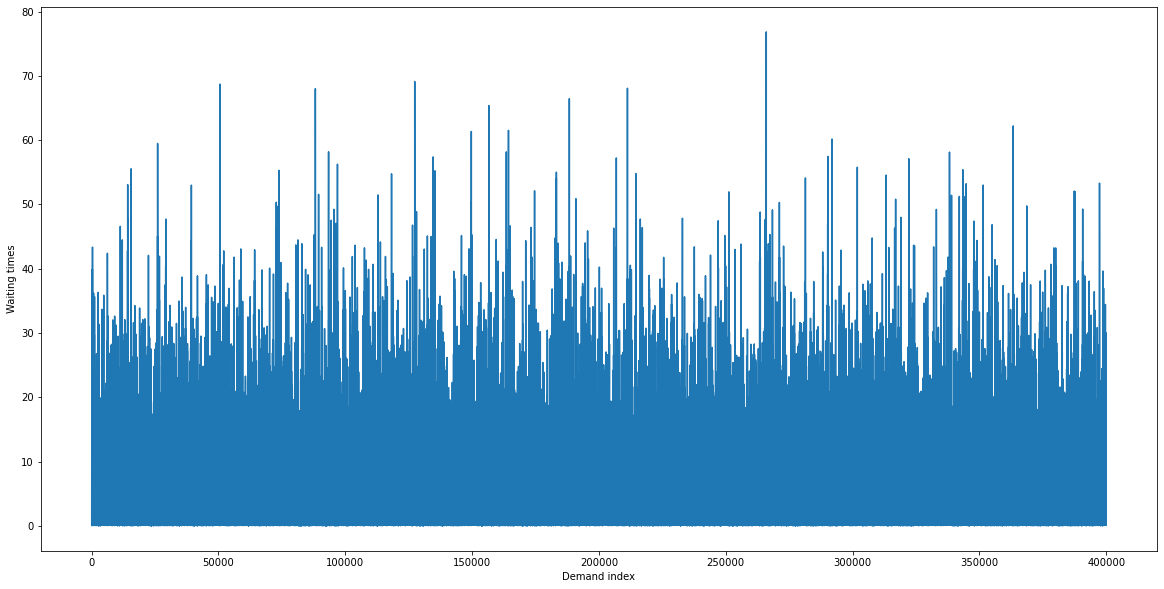

In [8]:
plt.figure(figsize=(20, 10))

plt.plot(range(simulation_demands_amount), result_waiting_times_array)

plt.title('')
plt.xlabel('Demand index')
plt.ylabel('Waiting times')
plt.show()

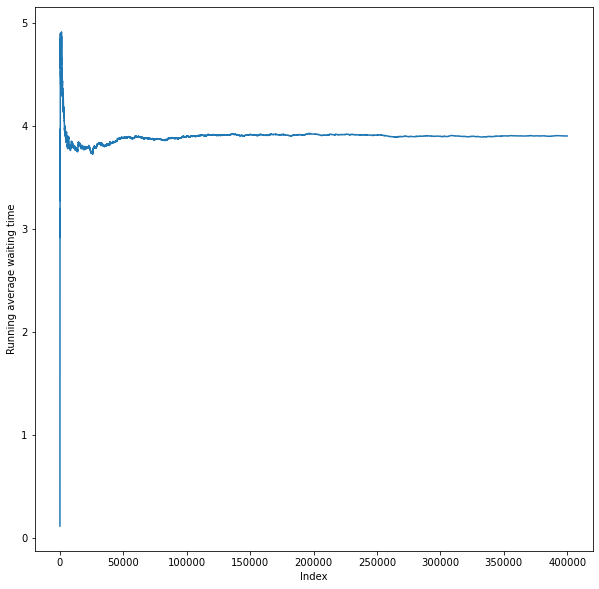

In [10]:
plt.figure(figsize=(10,10))

plt.plot(range(simulation_demands_amount), convergence)

plt.title('')
plt.xlabel('Index')
plt.ylabel('Running average waiting time')
plt.show()